### EasyOCR

In [ ]:
from pathlib import Path
import pandas as pd
import easyocr
import torch
import cv2
import time

IMAGES_DIR = Path(r"./imagesOCR")                  
OCR_CSV = Path(r"./ocr.csv")                
OUTPUT_FILE = Path(r"./resultados_easyocr.csv")                     
ALLOWLIST = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789" 
MIN_CONFIDENCE = 0.5                               

use_cuda = torch.cuda.is_available()
reader = easyocr.Reader(['es'], gpu=use_cuda)

results = []

def process_easyocr_from_csv(ocr_csv: Path, images_dir: Path, out_file: Path, allowlist=None, min_conf=0.5):
    start_time = time.time()

    # Leer coordenadas
    df = pd.read_csv(ocr_csv)
    if not {"filename", "x1", "y1", "x2", "y2"}.issubset(df.columns):
        raise ValueError("El archivo ocr.csv no contiene las coordenadas de la placa.")


    for _, row in df.iterrows():
        img_path = images_dir / row["filename"]
        if not img_path.exists():
            continue

        img = cv2.imread(str(img_path))
        if img is None:
            continue

        x1, y1, x2, y2 = map(int, [row["x1"], row["y1"], row["x2"], row["y2"]])
        roi = img[y1:y2, x1:x2]

        try:
            detections = reader.readtext(roi, allowlist=allowlist)
        except Exception as e:
            continue

        if not detections:
            results.append([img_path.name, "", 0.0])
            continue

        best_text = ""
        best_conf = 0.0
        for _, text, conf in detections:
            if conf > best_conf:
                best_text, best_conf = text.strip(), conf

        if best_conf >= min_conf:
            results.append([img_path.name, best_text, round(best_conf, 3)])
        else:
            results.append([img_path.name, "", round(best_conf, 3)])

    # Guardar CSV
    pd.DataFrame(results, columns=["filename", "text", "confidence"]).to_csv(out_file, index=False, encoding="utf-8")
    print(f"\nOCR completado. Resultados guardados en: {out_file}")

    elapsed = time.time() - start_time
    mins, secs = divmod(elapsed, 60)
    print(f"Tiempo total: {mins:.0f} min {secs:.1f} s\n")


if __name__ == "__main__":
    process_easyocr_from_csv(OCR_CSV, IMAGES_DIR, OUTPUT_FILE, allowlist=ALLOWLIST, min_conf=MIN_CONFIDENCE)



OCR completado. Resultados guardados en: resultados_easyocr.csv
Tiempo total: 0 min 14.9 s



### Tesseract

In [ ]:
import cv2, pytesseract, pandas as pd
from pytesseract import Output
from pathlib import Path

pytesseract.pytesseract.tesseract_cmd = r"C:/Program Files/Tesseract-OCR/tesseract.exe"

OCR_CSV = Path("./ocr.csv")
IMAGES_DIR = Path("./imagesOCR")
OUT_FILE = Path("./resultados_tesseract.csv")
LANGUAGE = "eng"
MIN_CONF = 60

df = pd.read_csv(OCR_CSV)
rows = []
start = time.time()
for _, row in df.iterrows():
    img_path = IMAGES_DIR / row["filename"]
    img = cv2.imread(str(img_path))
    if img is None: continue

    # recorta placa
    x1, y1, x2, y2 = int(row["x1"]), int(row["y1"]), int(row["x2"]), int(row["y2"])
    roi = img[y1:y2, x1:x2]
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    d = pytesseract.image_to_data(thresh, lang=LANGUAGE, config="--psm 7", output_type=Output.DICT)
    for i in range(len(d["text"])):
        try:
            conf = float(d["conf"][i])
        except:
            continue
        if conf < MIN_CONF:
            continue
        text = d["text"][i].strip()
        if not text:
            continue
        rows.append([row["filename"], text, conf])

elapsed = time.time() - start
mins, secs = divmod(elapsed, 60)
print(f"⏱️ Tiempo total: {mins:.0f} min {secs:.1f} s\n")
pd.DataFrame(rows, columns=["filename", "text", "confidence"]).to_csv(OUT_FILE, index=False, encoding="utf-8")
print("✅ OCR de placas guardado en:", OUT_FILE)


⏱️ Tiempo total: 0 min 48.1 s

✅ OCR de placas guardado en: resultados_tesseract.csv


### PaddleOCR

In [ ]:
from paddleocr import PaddleOCR
from pathlib import Path
import pandas as pd
import cv2
import time
import os


IMAGES_DIR = Path(r"./imagesOCR")                   
OCR_CSV = Path(r"./ocr.csv")                
OUTPUT_FILE = Path(r"./resultados_paddleocr.csv")  
LANGUAGE = "en"                                    
USE_GPU = True                                     
MIN_CONFIDENCE = 0.5  

ocr = PaddleOCR(use_angle_cls=True, lang='en')
results = []

def process_paddleocr_from_csv(ocr_csv: Path, images_dir: Path, out_file: Path, min_conf=0.5):
    start_time = time.time()

    df = pd.read_csv(ocr_csv)
    if not {"filename", "x1", "y1", "x2", "y2"}.issubset(df.columns):
        raise ValueError("El archivo ocr.csv no contiene las coordenadas de la placa.")

    for _, row in df.iterrows():
        img_path = images_dir / row["filename"]
        if not img_path.exists():
            continue

        img = cv2.imread(str(img_path))
        if img is None:
            continue

        x1, y1, x2, y2 = map(int, [row["x1"], row["y1"], row["x2"], row["y2"]])
        roi = img[y1:y2, x1:x2]

        if roi.size == 0:
            print(f"⚠️ ROI vacío para {img_path.name}")
            continue

        # Guardar ROI temporal (PaddleOCR solo acepta ruta o array)
        temp_path = str(images_dir / "__temp_roi.jpg")
        cv2.imwrite(temp_path, roi)

        try:
            preds = ocr.predict(temp_path)
        except Exception as e:
            continue
        finally:
            if os.path.exists(temp_path):
                os.remove(temp_path)

        if not preds or len(preds[0]["rec_texts"]) == 0:
            results.append([img_path.name, "", 0.0])
            continue

        # Tomar el texto más confiable
        rec_texts = preds[0]["rec_texts"]
        rec_scores = preds[0]["rec_scores"]

        best_idx = int(max(range(len(rec_scores)), key=lambda i: rec_scores[i]))
        best_text = rec_texts[best_idx].strip()
        best_conf = float(rec_scores[best_idx])

        if best_conf >= min_conf:
            results.append([img_path.name, best_text, round(best_conf, 3)])
        else:
            results.append([img_path.name, "", round(best_conf, 3)])

    # Guardar CSV
    if results:
        pd.DataFrame(results, columns=["filename", "text", "confidence"]).to_csv(out_file, index=False, encoding="utf-8")
        print(f"\nResultados guardados en: {out_file}")
    else:
        print("\nNo se obtuvieron resultados válidos.")

    elapsed = time.time() - start_time
    mins, secs = divmod(elapsed, 60)
    print(f"Tiempo total: {mins:.0f} min {secs:.1f} s\n")


process_paddleocr_from_csv(OCR_CSV, IMAGES_DIR, OUTPUT_FILE, min_conf=MIN_CONFIDENCE)


c:\Users\antho\anaconda3\envs\VC_P4B\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 Inicializando PaddleOCR (lang=en ...


C:\Users\antho\AppData\Local\Temp\ipykernel_16636\4110576245.py:43: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr = PaddleOCR(use_angle_cls=True, lang=lang)
C:\Users\antho\AppData\Roaming\Python\Python311\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\antho\.paddlex\official_models\PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\antho\.paddlex\official_models\


✅ OCR completado. Resultados guardados en: resultados_paddleocr.csv
⏱️ Tiempo total: 7 min 42.2 s



### SmolVLM

In [ ]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText
from pathlib import Path
import pandas as pd
from PIL import Image
import cv2
from tqdm import tqdm
import time


IMAGES_DIR = Path(r"./imagesOCR")                 
OCR_CSV = Path(r"./ocr.csv")               
OUTPUT_FILE = Path(r"./resultados_smolvlm.csv") 
             
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
results = []

dtype = torch.bfloat16 if DEVICE == "cuda" else torch.float32
processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
model = AutoModelForImageTextToText.from_pretrained(
    "HuggingFaceTB/SmolVLM-Instruct",
    torch_dtype=dtype,
    _attn_implementation="eager"
).to(DEVICE)
model.eval()

def run_smolvlm_roi(processor, model, ocr_csv, images_dir, out_file, device=DEVICE):
    df = pd.read_csv(ocr_csv)
    if not {"filename", "x1", "y1", "x2", "y2"}.issubset(df.columns):
        raise ValueError("El archivo ocr.csv no contiene las coordenadas de la placa.")

    total_imgs = len(df)
    start_time = time.time()

    for _, row in tqdm(df.iterrows(), total=total_imgs, ncols=100, desc="Procesando imágenes"):
        img_path = images_dir / row["filename"]
        if not img_path.exists():
            continue

        img = cv2.imread(str(img_path))
        if img is None:
            continue

        x1, y1, x2, y2 = map(int, [row["x1"], row["y1"], row["x2"], row["y2"]])
        roi = img[y1:y2, x1:x2]
        if roi.size == 0:
            continue

        image_pil = Image.fromarray(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))

        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": "What text is visible in the license plate?"}
                ]
            }
        ]
        prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=prompt, images=[image_pil], return_tensors="pt").to(device)

        t0 = time.time()
        try:
            with torch.no_grad():
                gen_ids = model.generate(**inputs, max_new_tokens=12)
                text = processor.batch_decode(gen_ids, skip_special_tokens=True)[0]
        except Exception as e:
            continue
        elapsed = time.time() - t0

        # Limpieza de texto
        text_clean = text.strip().replace("\n", " ")
        results.append([row["filename"], text_clean, round(elapsed, 2)])

    # Guardar CSV
    if results:
        df_out = pd.DataFrame(results, columns=["filename", "text", "seconds"])
        df_out.to_csv(out_file, index=False, encoding="utf-8")
        print(f"\nOCR completado. Resultados guardados en: {out_file}")
    else:
        print("\nNo se obtuvieron resultados válidos.")

    total_elapsed = time.time() - start_time
    mins, secs = divmod(total_elapsed, 60)
    print(f"Tiempo total: {mins:.0f} min {secs:.1f} s ({total_imgs} imágenes procesadas)\n")


run_smolvlm_roi(processor, model, OCR_CSV, IMAGES_DIR, OUTPUT_FILE, DEVICE)


🚀 Cargando SmolVLM en CUDA ...


Procesando imágenes: 100%|██████████████████████████████████████| 443/443 [4:12:33<00:00, 34.21s/it]


✅ OCR completado. Resultados guardados en: resultados_smolvlm.csv
⏱️ Tiempo total: 252 min 33.5 s (443 imágenes procesadas)



⏱️ Comparación completada en 0 min 0.0 s.
      OCR  Imágenes   0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.0
  easyocr       404 71.53 66.58 57.43 54.21 51.24 45.30 43.07 39.36 31.19 26.98
tesseract       222 85.59 81.98 76.13 54.50 50.90 23.42 11.26  4.95  4.05  2.70
paddleocr       404 81.68 77.23 71.29 67.08 63.12 55.45 52.23 47.28 35.15 15.35
  smolvlm       404 97.03 96.53 93.81 92.82 89.60 85.40 77.48 64.36 25.00  6.19


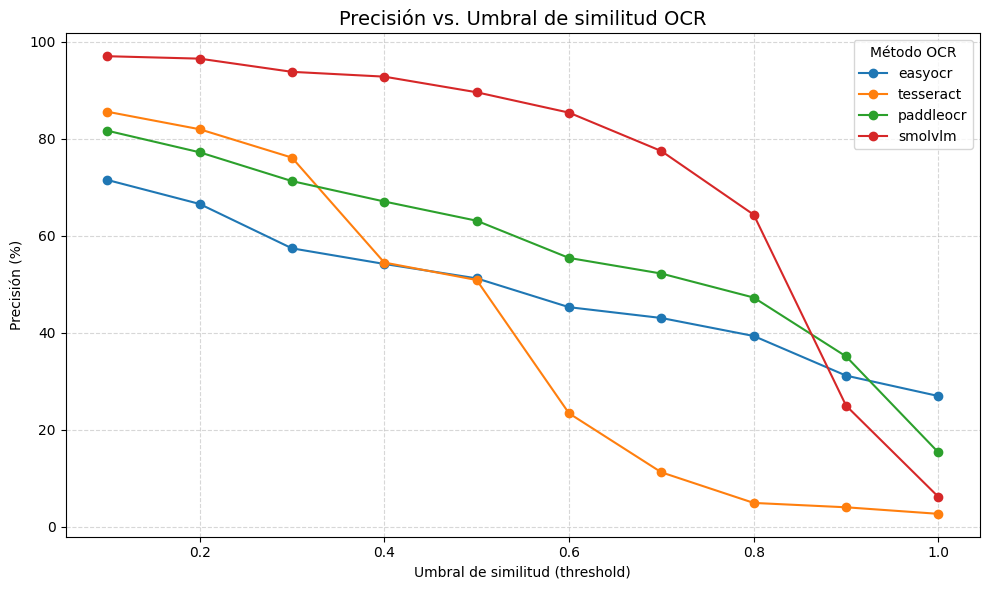

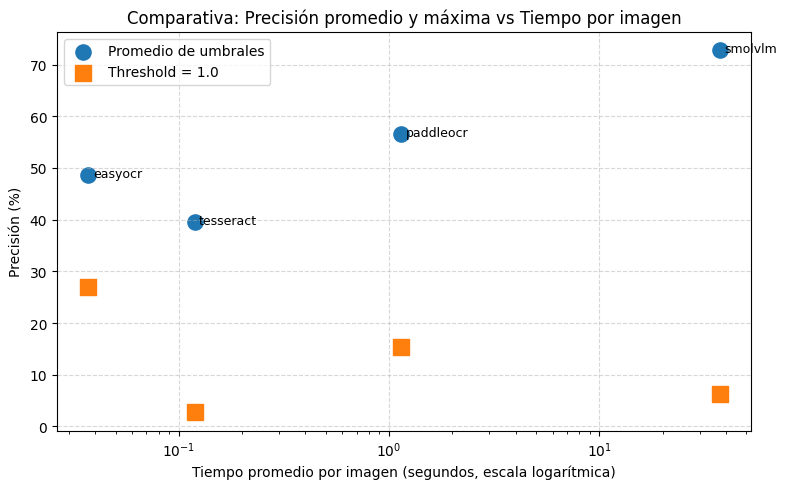

In [ ]:
from pathlib import Path
import pandas as pd
from difflib import SequenceMatcher
import time
import matplotlib.pyplot as plt

OCR_TIMES = {
    "easyocr": 0.25,       # 0 min 14.9 s → 0.25 min
    "tesseract": 0.8,      # 48.1 s → 0.8 min
    "paddleocr": 7.7,      # 7 min 42.2 s
    "smolvlm": 252.5,      # 252 min 33.5 s
}

# === ARCHIVOS BASE ===
REAL_CSV = Path("./ocr.csv")  # OCR real (etiquetado manual)
PRED_FILES = {
    "easyocr": Path("./resultados_easyocr.csv"),
    "tesseract": Path("./resultados_tesseract.csv"),
    "paddleocr": Path("./resultados_paddleocr.csv"),
    "smolvlm": Path("./resultados_smolvlm.csv"),
}
OUTPUT_REPORT = Path("./comparacion_multi_umbral.csv")  # Salida

# === CONFIGURACIÓN ===
EXCLUDE_IMAGES = [
    "Cars5.png","Cars16.png","Cars20.png","Cars75.png","Cars87.png","Cars90.png","Cars93.png",
    "Cars103.png","Cars119.png","Cars121.png","Cars124.png","Cars127.png","Cars132.png","Cars141.png",
    "Cars146.png","Cars168.png","Cars174.png","Cars214.png","Cars221.png","Cars236.png","Cars253.png",
    "Cars283.png","Cars337.png","Cars338.png","Cars347.png","Cars352.png","Cars354.png","Cars388.png",
    "Cars421.png"
]

TOTAL_IMAGES = 433 - len(EXCLUDE_IMAGES)

THRESHOLDS = [i * 0.10 for i in range(1, 11)]  # 0.1, 0.2, ..., 1.0


# === FUNCIONES ===
def string_similarity(a: str, b: str) -> float:
    """Calcula la similitud entre dos cadenas [0-1]."""
    return SequenceMatcher(None, a.strip().lower(), b.strip().lower()).ratio()


def normalize_csv(df: pd.DataFrame) -> pd.DataFrame:
    """Estandariza columnas para filename/text."""
    df = df.copy()
    if "filename" not in df.columns:
        df.rename(columns={df.columns[0]: "filename"}, inplace=True)
    if "plate_text" in df.columns:
        df.rename(columns={"plate_text": "text"}, inplace=True)
    elif len(df.columns) > 1:
        df.rename(columns={df.columns[1]: "text"}, inplace=True)
    return df


def compare_multi_thresholds(real_csv: Path, pred_files: dict, thresholds, exclude_images=None, out_file=None):
    """Compara varios OCRs con distintos thresholds y genera una tabla de precisión."""
    start = time.time()

    df_real = normalize_csv(pd.read_csv(real_csv))
    if exclude_images:
        df_real = df_real[~df_real["filename"].isin(exclude_images)]

    summary_rows = []

    for name, pred_path in pred_files.items():
        if not pred_path.exists():
            print(f"⚠️ {name}: archivo no encontrado, se omite.")
            continue

        df_pred = normalize_csv(pd.read_csv(pred_path))
        if exclude_images:
            df_pred = df_pred[~df_pred["filename"].isin(exclude_images)]

        merged = pd.merge(df_real, df_pred, on="filename", how="inner", suffixes=("_real", "_pred"))
        if merged.empty:
            print(f"⚠️ {name}: sin coincidencias entre CSVs, se omite.")
            continue

        merged["similarity"] = merged.apply(
            lambda r: string_similarity(str(r["text_real"]), str(r["text_pred"])), axis=1
        )

        row = {"OCR": name, "Imágenes": len(merged)}
        for t in thresholds:
            correct = (merged["similarity"] >= t).sum()
            row[f"{t:.1f}"] = round(correct / len(merged) * 100, 2)
        summary_rows.append(row)

    if not summary_rows:
        print("❌ No se pudo comparar ningún OCR.")
        return

    df_summary = pd.DataFrame(summary_rows)
    df_summary = df_summary[["OCR", "Imágenes"] + [f"{t:.1f}" for t in thresholds]]

    if out_file:
        df_summary.to_csv(out_file, index=False, encoding="utf-8")

    elapsed = time.time() - start
    mins, secs = divmod(elapsed, 60)
    print(f"⏱️ Comparación completada en {mins:.0f} min {secs:.1f} s.")
    print(df_summary.to_string(index=False))

    # === GRAFICAR PRECISIÓN POR UMBRAL ===
    plt.figure(figsize=(10, 6))
    thresholds_labels = [f"{t:.1f}" for t in thresholds]

    for _, row in df_summary.iterrows():
        ocr_name = row["OCR"]
        y_values = [row[t] for t in thresholds_labels]
        plt.plot(thresholds, y_values, marker="o", label=ocr_name)

    plt.title("Precisión vs. Umbral de similitud OCR", fontsize=14)
    plt.xlabel("Umbral de similitud (threshold)")
    plt.ylabel("Precisión (%)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(title="Método OCR", loc="best")
    plt.tight_layout()
    plt.show()

    # === COMPARATIVA DE PRECISIÓN PROMEDIO Y THRESHOLD=1 vs TIEMPO POR IMAGEN ===
    plt.figure(figsize=(8, 5))

    # Calcular promedio global y precisión con t=1.0
    df_summary["Promedio"] = df_summary[[f"{t:.1f}" for t in thresholds]].mean(axis=1)
    df_summary["Precisión (t=1.0)"] = df_summary["1.0"]

    # Calcular tiempo promedio por imagen (en segundos)
    df_summary["Tiempo (s/img)"] = df_summary["OCR"].map(OCR_TIMES).apply(lambda m: (m * 60) / TOTAL_IMAGES)

    # Graficar ambos puntos para cada OCR
    plt.scatter(df_summary["Tiempo (s/img)"], df_summary["Promedio"],
                s=120, c="tab:blue", label="Promedio de umbrales", marker="o")
    plt.scatter(df_summary["Tiempo (s/img)"], df_summary["Precisión (t=1.0)"],
                s=120, c="tab:orange", label="Threshold = 1.0", marker="s")

    # Etiquetas de cada OCR
    for _, row in df_summary.iterrows():
        plt.text(row["Tiempo (s/img)"] * 1.05, row["Promedio"] + 0.3, row["OCR"],
                 fontsize=9, va="center")

    plt.xscale("log")
    plt.xlabel("Tiempo promedio por imagen (segundos, escala logarítmica)")
    plt.ylabel("Precisión (%)")
    plt.title("Comparativa: Precisión promedio y máxima vs Tiempo por imagen")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


    return df_summary



# === EJECUCIÓN ===
if __name__ == "__main__":
    compare_multi_thresholds(
        real_csv=REAL_CSV,
        pred_files=PRED_FILES,
        thresholds=THRESHOLDS,
        exclude_images=EXCLUDE_IMAGES,
        out_file=OUTPUT_REPORT,
    )
